In [93]:
# to make tab autocomplete work
%config Completer.use_jedi = False

In [488]:
# imoprt packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [2]:
# read data
dim_pa_claims_rejected = pd.read_csv('../CoverMyMeds_data/dim_pa_claim_rejected.csv')

In [3]:
dim_pa_claims_rejected.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,reject_reason,dim_pa_id,dim_date_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved,Type
0,1,417380,A,75.0,0,In_formulary_needs_PA,1.0,1,1,1,0,1,T2
1,3,417740,A,76.0,0,Limit_exceeded,2.0,1,1,0,0,1,T1
2,10,417380,A,75.0,0,In_formulary_needs_PA,3.0,1,0,0,1,1,T7
3,11,999001,A,76.0,0,Limit_exceeded,4.0,1,1,1,0,1,T2
4,15,417614,A,70.0,0,Not_in_formulary,5.0,1,0,1,0,1,T5


In [243]:
# correlation of features and pa_approved
dim_pa_claims_rejected[['bin','reject_code','correct_diagnosis','tried_and_failed','contraindication','pa_approved']].corr()['pa_approved']

bin                  0.140196
reject_code          0.475336
correct_diagnosis    0.035889
tried_and_failed     0.125490
contraindication    -0.223283
pa_approved          1.000000
Name: pa_approved, dtype: float64

In [439]:
# Seperate dim_pa_claims_rejected into X and y

X = dim_pa_claims_rejected[['bin','drug', 'reject_reason','correct_diagnosis','tried_and_failed','contraindication']]
y = dim_pa_claims_rejected['pa_approved']

In [440]:
# Add new column payer
# convert bin from int to str
X_copy = X.copy()
X_copy['payer'] = ''

X_copy.loc[X_copy.bin==417380, 'payer'] = 'C1'
X_copy.loc[X_copy.bin==999001, 'payer'] = 'C2'
X_copy.loc[X_copy.bin==417740, 'payer'] = 'C3'
X_copy.loc[X_copy.bin==417614, 'payer'] = 'C4'

In [441]:
X_copy.head()

,bin,drug,reject_reason,correct_diagnosis,tried_and_failed,contraindication,payer
0,417380,A,In_formulary_needs_PA,1,1,0,C1
1,417740,A,Limit_exceeded,1,0,0,C3
2,417380,A,In_formulary_needs_PA,0,0,1,C1
3,999001,A,Limit_exceeded,1,1,0,C2
4,417614,A,Not_in_formulary,0,1,0,C4


In [460]:
# interaction terms

X_copy['drug_payer_reject_reason'] = X_copy['drug'].astype(str) + X_copy['payer'].astype(str) + X_copy['reject_reason']
X_copy['diagnosis'] = X_copy['correct_diagnosis'].astype(str) + X_copy['tried_and_failed'].astype(str) + X_copy['contraindication'].astype(str)

In [461]:
X_copy.head()

,bin,drug,reject_reason,correct_diagnosis,tried_and_failed,contraindication,payer,drug_payer,drug_payer_reject_reason,diagnosis
0,417380,A,In_formulary_needs_PA,1,1,0,C1,AC1,AC1In_formulary_needs_PA,110
1,417740,A,Limit_exceeded,1,0,0,C3,AC3,AC3Limit_exceeded,100
2,417380,A,In_formulary_needs_PA,0,0,1,C1,AC1,AC1In_formulary_needs_PA,001
3,999001,A,Limit_exceeded,1,1,0,C2,AC2,AC2Limit_exceeded,110
4,417614,A,Not_in_formulary,0,1,0,C4,AC4,AC4Not_in_formulary,010


#### I tried using interaction terms, it did not have any influence on the accuracy/roc_auc of the model.

In [538]:
# One Hot Encoding
X_final = X_copy[['diagnosis','drug_payer_reject_reason']]
X_enc=pd.get_dummies(X_final, drop_first=True)

In [539]:
X_enc.columns

Index(['diagnosis_001', 'diagnosis_010', 'diagnosis_011', 'diagnosis_100',
       'diagnosis_101', 'diagnosis_110', 'diagnosis_111',
       'drug_payer_reject_reason_AC2Limit_exceeded',
       'drug_payer_reject_reason_AC3Limit_exceeded',
       'drug_payer_reject_reason_AC4Not_in_formulary',
       'drug_payer_reject_reason_BC1Limit_exceeded',
       'drug_payer_reject_reason_BC2Limit_exceeded',
       'drug_payer_reject_reason_BC3Not_in_formulary',
       'drug_payer_reject_reason_BC4In_formulary_needs_PA',
       'drug_payer_reject_reason_CC1Not_in_formulary',
       'drug_payer_reject_reason_CC2Limit_exceeded',
       'drug_payer_reject_reason_CC3In_formulary_needs_PA',
       'drug_payer_reject_reason_CC4Limit_exceeded'],
      dtype='object')

In [540]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state =42, shuffle = True, test_size = 0.25, stratify = y)

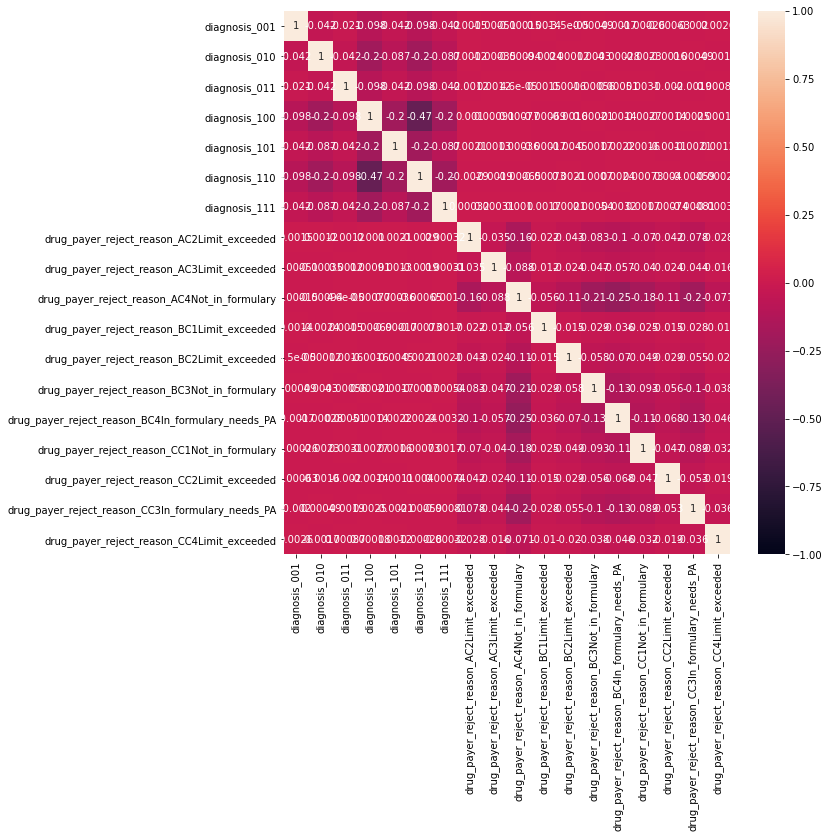

In [541]:
# correlation between features
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)

In [505]:
# calculate class weights
# Wj = n_samples / (n_classes * n_samples_j)

W_0 = len(y)/(2*len(y[y==0]))
W_1 = len(y)/(2*len(y[y==1]))

print(W_0)
print (W_1)

1.8828946298905387
0.6807802233057977


In [542]:
# Logistic regression
clf = LogisticRegression(random_state =42, solver = 'lbfgs', max_iter = 1000,class_weight={0:W_0,1:W_1})

In [543]:
# cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# evaluate model
scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# report performance
print (scores)
print('ROC_AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

[0.87868341 0.87676766 0.88015283 0.87776555 0.87734253]
ROC_AUC: 0.878 (0.001)


In [564]:
clf.fit(X_train,y_train)
clf.coef_

array([[-2.06377915,  0.90888033, -0.99990108,  0.31762955, -1.6830638 ,
         1.21728102, -0.65021122, -1.41062196, -2.53372598, -4.77376549,
        -2.459655  , -2.08502047, -5.67509401, -1.03899477, -5.96719381,
        -3.77404119, -3.24027895, -4.43383899]])

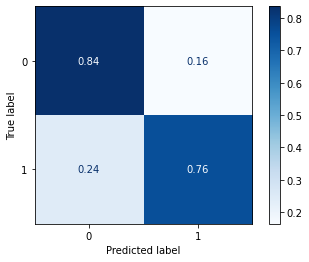

In [545]:
# confusion matrix
plot_confusion_matrix(clf, X_train, y_train,cmap=plt.cm.Blues, normalize='true')
plt.show()  

In [546]:
# predict probabilities
y_pred=clf.predict_proba(X_train)[:,1]

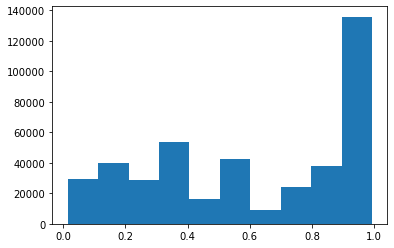

In [547]:
# select threshold
plt.hist(y_pred)
plt.show()

#thresh = 0.7

<AxesSubplot:>

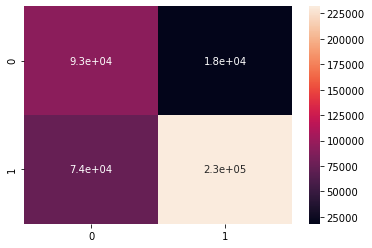

In [552]:
thresh = 0.5
y_test_pred = np.where(y_pred>thresh, 1, 0)
cm = confusion_matrix(y_train,y_test_pred)
sns.heatmap(cm, annot=True)

In [ ]:
['diagnosis_001', 'diagnosis_010', 'diagnosis_011', 'diagnosis_100',
       'diagnosis_101', 'diagnosis_110', 'diagnosis_111',
       'drug_payer_reject_reason_AC2Limit_exceeded',
       'drug_payer_reject_reason_AC3Limit_exceeded',
       'drug_payer_reject_reason_AC4Not_in_formulary',
       'drug_payer_reject_reason_BC1Limit_exceeded',
       'drug_payer_reject_reason_BC2Limit_exceeded',
       'drug_payer_reject_reason_BC3Not_in_formulary',
       'drug_payer_reject_reason_BC4In_formulary_needs_PA',
       'drug_payer_reject_reason_CC1Not_in_formulary',
       'drug_payer_reject_reason_CC2Limit_exceeded',
       'drug_payer_reject_reason_CC3In_formulary_needs_PA',
       'drug_payer_reject_reason_CC4Limit_exceeded']

In [573]:
correct_diagnosis = 1
tried_and_failed = 0
contraindication = 0
drug_A = 1
drug_B = 0
drug_C = 0
payer_C1 = 0
payer_C2 = 1
payer_C3 = 0
payer_C4 = 0
reject_reason_In_formulary_needs_PA = 0
reject_reason_Limit_exceeded = 1
reject_reason_Not_in_formulary = 0

diagnosis = str(correct_diagnosis)+str(tried_and_failed)+str(contraindication)
drug_payer_reject = 

arr = np.array(['001','010','011','100','101','110','111', correct_diagnosis, tried_and_failed, contraindication, drug_B,
       drug_C, payer_C2, payer_C3, payer_C4,
       reject_reason_Limit_exceeded, reject_reason_Not_in_formulary])

clf.predict_proba(arr.reshape(1,-1))[0][1]


SyntaxError: invalid syntax (<ipython-input-573-8eb446757758>, line 16)

# Statsmodels
#### To check the significance of the model

In [381]:
import statsmodels.api as sm

In [558]:
model = sm.Logit(endog=y_train, exog=sm.add_constant(X_train)).fit()

Optimization terminated successfully.
         Current function value: 0.371655
         Iterations 9


In [559]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:            pa_approved   No. Observations:               416963
Model:                          Logit   Df Residuals:                   416944
Method:                           MLE   Df Model:                           18
Date:                Thu, 20 May 2021   Pseudo R-squ.:                  0.3579
Time:                        18:30:27   Log-Likelihood:            -1.5497e+05
converged:                       True   LL-Null:                   -2.4133e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                 4.7695      0.043    111.774      0.000       4.686       4.853
diagnosis_001 

In [566]:
print(np.exp(model.params))

const                                                117.865668
diagnosis_001                                          0.136172
diagnosis_010                                          2.476093
diagnosis_011                                          0.391947
diagnosis_100                                          1.383043
diagnosis_101                                          0.199437
diagnosis_110                                          3.371625
diagnosis_111                                          0.545053
drug_payer_reject_reason_AC2Limit_exceeded             0.236241
drug_payer_reject_reason_AC3Limit_exceeded             0.078252
drug_payer_reject_reason_AC4Not_in_formulary           0.008605
drug_payer_reject_reason_BC1Limit_exceeded             0.084252
drug_payer_reject_reason_BC2Limit_exceeded             0.119806
drug_payer_reject_reason_BC3Not_in_formulary           0.003488
drug_payer_reject_reason_BC4In_formulary_needs_PA      0.341784
drug_payer_reject_reason_CC1Not_in_formu